In [1]:
##IMPORT REQUIRED LIBRARY FILES

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers

import os
mylist= os.listdir('RAW_DATAS/')
type(mylist)

list

In [2]:
print(mylist[2])

03-01-02-01-01-01-03.wav


In [3]:
print(mylist[400][6:-16])

04


In [4]:
##Plotting the audio file's waveform and its spectrogram

data, sampling_rate = librosa.load('RAW_DATAS/03-01-02-01-01-01-01.wav')

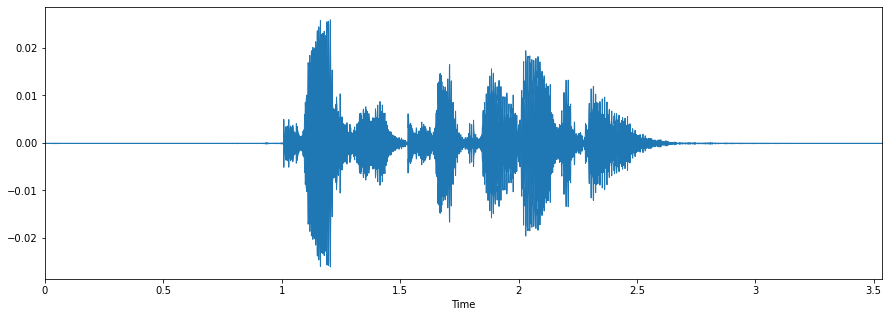

In [5]:
# pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

<ipython-input-6-fbfec8eb8573>:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('RAW_DATAS/03-01-02-01-01-01-01.wav')
<ipython-input-6-fbfec8eb8573>:6: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  sr,x = scipy.io.wavfile.read('RAW_DATAS/03-01-02-01-01-01-01.wav')
<ipython-input-6-fbfec8eb8573>:23: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


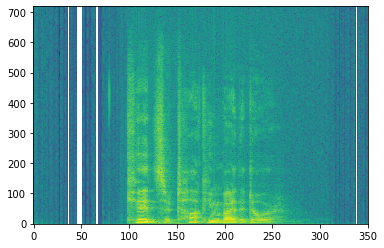

In [6]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys

sr,x = scipy.io.wavfile.read('RAW_DATAS/03-01-02-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )
for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [7]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [8]:
labels = pd.DataFrame(feeling_list)

In [9]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,male_calm


In [10]:
##GETTING THE FEATURES OF AUDIO FILES USING LIBROSA

df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RAW_DATAS/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [11]:
df[:5]

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-65.70765, -65.70765, -63.11472, -61.518997, ..."
2,"[-65.4825, -65.4825, -65.4825, -65.4825, -65.4..."
3,"[-64.52845, -64.52845, -64.52845, -64.52845, -..."
4,"[-62.36431, -59.934727, -61.869602, -67.49577,..."


In [12]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [13]:
newdf = pd.concat([df3,labels], axis=1)

In [14]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [15]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-57.447464,-58.896500,-58.750996,-57.405678,-60.078487,-63.426796,-62.638535,-61.082741,-60.234661,male_calm
1,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-39.792141,-40.613163,-41.209209,-41.439201,-43.994286,-49.399620,-50.591599,-49.144051,-48.705650,female_calm
2,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-31.346554,-34.310772,-35.800705,-35.936115,-37.631840,-40.119411,-41.662888,-41.323635,-40.710770,male_calm
3,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.674301,-48.596073,-47.602745,-43.049198,-42.659542,-43.188560,-44.001240,-43.610100,-44.698246,female_calm
4,-62.364311,-59.934727,-61.869602,-67.495773,-71.071808,-65.679817,-63.394402,-65.503349,-61.856644,-60.005428,...,-39.071327,-41.897121,-40.865433,-38.290604,-36.372398,-37.915779,-40.026127,-43.383774,-43.965397,male_calm


In [16]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1081,-60.965450,-60.965450,-60.965450,-57.991428,-54.958981,-54.750053,-52.548576,-51.560989,-52.523525,-52.540222,...,-31.178562,-31.757507,-32.659534,-32.905758,-33.882267,-35.883530,-35.601692,-26.817717,-22.156260,male_happy
1743,-47.044193,-47.289349,-47.470638,-48.799614,-49.333187,-49.770626,-51.110378,-50.408272,-48.978878,-49.951946,...,-43.393440,-43.701225,-43.187355,-42.882408,-41.781040,-40.758301,-40.495689,-26.161119,-17.332867,female_fearful
840,-35.372734,-36.900326,-38.971115,-38.443577,-37.651360,-38.045128,-38.624802,-42.541161,-43.463238,-43.102676,...,-29.331697,-27.650185,-31.414619,-34.811462,-34.607101,-35.440926,-35.538506,-36.477863,-35.934353,male_fearful
682,-41.589390,-41.589390,-41.589390,-41.589390,-41.589390,-41.589390,-41.589390,-41.589390,-41.589390,-41.589390,...,-21.879768,-21.297997,-16.639414,-14.185689,-13.375396,-14.768592,-15.129278,-11.527274,-7.073745,male_angry
201,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,-60.418480,...,-56.310959,-57.144508,-57.759190,-56.183907,-56.088951,-57.717632,-58.577389,-58.642826,-58.262722,female_happy
645,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,-45.123066,...,-29.173199,-29.597273,-29.886309,-30.992016,-30.784466,-30.693970,-32.584354,-32.333904,-28.859694,female_angry
426,-63.790466,-63.947464,-63.355610,-63.286247,-63.246239,-62.802952,-62.743813,-62.665565,-62.665565,-62.665565,...,-53.914062,-52.145931,-52.200077,-52.263313,-53.177227,-53.587490,-54.778587,-55.114738,-54.505997,female_sad
536,-53.756645,-53.756645,-53.756645,-53.756645,-53.756645,-53.756645,-53.756645,-53.756645,-53.756645,-53.756645,...,-49.024982,-46.917507,-46.717751,-46.505657,-45.347420,-47.946861,-52.490700,-51.263981,-50.633480,female_angry
365,-59.813412,-61.985203,-60.695007,-59.390869,-64.645241,-75.316528,-76.921661,-73.998604,-67.577606,-61.562508,...,-62.754715,-61.144920,-58.527615,-56.122105,-55.301731,-55.233158,-54.453384,-55.791344,-61.476040,male_sad
19,-61.308334,-61.715248,-63.512856,-61.015362,-58.811012,-57.962849,-57.511395,-57.648685,-59.732426,-61.305008,...,-59.425270,-59.087593,-61.429996,-66.197762,-64.429329,-59.176353,-56.783169,-58.191391,-62.347534,female_calm


In [17]:
rnewdf=rnewdf.fillna(0)

In [18]:
## DIVIDING THE DATA INTO TEST AND TRAIN

newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [19]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
689,-55.858765,-55.858765,-55.858765,-55.858765,-55.858765,-55.858765,-55.858765,-55.858765,-55.915096,-56.569260,...,-55.858765,-55.858765,-55.858765,-55.858765,-55.644516,-55.451286,-54.692135,-55.764381,-55.858765,female_fearful
112,-56.940056,-56.639664,-57.791435,-58.812050,-57.636192,-56.253441,-56.451939,-57.593510,-58.072014,-58.984097,...,-22.885700,-23.409218,-22.345482,-22.443972,-23.253521,-23.589235,-23.309929,-23.935581,-23.651937,male_calm
115,-70.692863,-69.985161,-71.187744,-70.811371,-69.813614,-69.616936,-68.459938,-70.129707,-72.018173,-72.018173,...,-45.056293,-45.750526,-44.787312,-43.502945,-44.521019,-44.736515,-45.162476,-44.443619,-45.885380,female_calm
394,-62.949284,-61.668442,-62.001259,-60.142002,-60.433285,-64.699104,-69.395538,-67.677116,-68.727585,-66.632462,...,-59.054630,-56.488419,-58.638565,-60.799847,-65.953331,-69.733299,-69.372871,-68.776337,-69.733299,male_sad
126,-50.395935,-52.036770,-53.322956,-53.681828,-53.737862,-52.723572,-51.938457,-51.223721,-52.601021,-52.437778,...,-28.124722,-28.800528,-28.736748,-28.625130,-29.070343,-29.151936,-29.545986,-29.642231,-27.836397,male_calm
1053,-50.891655,-49.888039,-50.578445,-51.955009,-51.376186,-52.027908,-53.675362,-53.332291,-50.676846,-51.068867,...,-40.372601,-42.434170,-42.362808,-44.243896,-44.202946,-44.781883,-44.074604,-37.998619,-31.534132,female_happy
87,-66.807152,-67.642662,-67.920082,-68.177963,-67.961411,-67.855782,-68.056358,-67.975601,-67.535530,-67.833168,...,-58.913944,-57.802608,-59.957993,-62.548847,-66.173965,-64.493240,-62.488815,-63.460308,-64.412659,female_calm
1583,-53.028316,-53.028316,-53.028316,-53.028316,-53.028316,-53.028316,-53.028316,-53.028316,-53.028316,-53.028316,...,-14.258404,-14.671274,-14.921193,-17.314035,-17.665489,-18.489521,-19.676226,-17.463909,-12.829062,male_angry
199,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.040768,-61.049198,...,-53.759277,-53.623848,-55.661297,-53.975624,-54.425545,-56.314812,-56.524208,-54.678974,-55.443382,female_happy
1114,-51.510674,-52.134441,-50.338688,-48.809872,-47.647583,-47.767334,-46.396553,-44.680435,-46.629372,-46.937229,...,-37.903355,-39.516228,-39.383801,-39.043419,-37.572464,-36.992790,-39.101448,-32.332230,-24.592628,female_happy


In [20]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [21]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [22]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [23]:
X_train.shape

(1421, 216)

In [24]:
## CHANGING DIMENSION FOR CNN MODE

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

model = Sequential()
model.add(Conv1D(256, 5,padding='same',input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [27]:
## REMOVED THE WHOLE TRAING PART FOR AVOIDING UNNECESSARY LONG EPOCH LIST

cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
89/89 [==============================] - 8s 91ms/step - loss: 2.4039 - accuracy: 0.1161 - val_loss: 2.2824 - val_accuracy: 0.1163
Epoch 2/700
89/89 [==============================] - 9s 99ms/step - loss: 2.2599 - accuracy: 0.1450 - val_loss: 2.2428 - val_accuracy: 0.1413
Epoch 3/700
89/89 [==============================] - 9s 106ms/step - loss: 2.2116 - accuracy: 0.1809 - val_loss: 2.2084 - val_accuracy: 0.1773
Epoch 4/700
89/89 [==============================] - 9s 104ms/step - loss: 2.1791 - accuracy: 0.1928 - val_loss: 2.1598 - val_accuracy: 0.1773
Epoch 5/700
89/89 [==============================] - 9s 105ms/step - loss: 2.1446 - accuracy: 0.2034 - val_loss: 2.1510 - val_accuracy: 0.2133
Epoch 6/700
89/89 [==============================] - 9s 105ms/step - loss: 2.1138 - accuracy: 0.2160 - val_loss: 2.0987 - val_accuracy: 0.2687
Epoch 7/700
89/89 [==============================] - 9s 105ms/step - loss: 2.0775 - accuracy: 0.2456 - val_loss: 2.0930 - val_accuracy: 0.2798
E

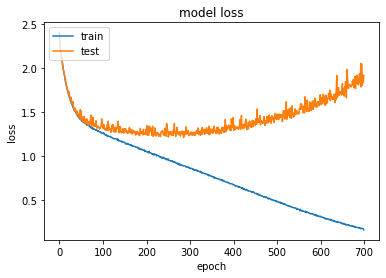

In [28]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
## SAVING THE MODEL

model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\aksha\saved_models\Emotion_Voice_Detection_Model.h5 


In [51]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [119]:
## LOADING THE MODEL

# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 45.43%


In [53]:
## PREDICTING EMOTIONS ON THE TEST DATA

preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)

12/12 [==============================] - 0s 35ms/step


In [54]:
preds

array([[1.7104545e-05, 1.3675708e-10, 7.0539596e-09, ..., 7.8278214e-02,
        3.7280361e-03, 9.1369003e-01],
       [3.4203995e-02, 7.1898580e-06, 6.7309093e-01, ..., 1.7883759e-03,
        1.2388806e-03, 1.5168894e-03],
       [1.2423232e-04, 2.5572944e-10, 9.9753261e-01, ..., 6.2640225e-05,
        3.9559698e-09, 2.5281040e-06],
       ...,
       [1.9584417e-01, 1.4840597e-03, 7.2789365e-01, ..., 4.7587971e-05,
        2.0778773e-06, 1.1714023e-03],
       [9.6911043e-01, 1.5411374e-08, 1.1195117e-05, ..., 2.3000701e-05,
        2.7550112e-03, 1.4434063e-03],
       [2.3525922e-01, 2.5270600e-05, 5.6394804e-03, ..., 2.0618587e-04,
        2.4348870e-07, 2.8604771e-05]], dtype=float32)

In [55]:
preds1=preds.argmax(axis=1)

In [56]:
preds1

array([9, 2, 2, 3, 1, 9, 7, 8, 3, 9, 3, 8, 0, 5, 0, 8, 1, 8, 3, 7, 5, 0,
       5, 8, 3, 8, 8, 0, 8, 2, 5, 6, 7, 5, 0, 6, 0, 6, 2, 8, 8, 0, 1, 7,
       8, 8, 5, 7, 3, 5, 5, 4, 8, 3, 6, 8, 0, 4, 8, 8, 4, 9, 6, 5, 0, 6,
       5, 0, 4, 3, 1, 5, 2, 8, 8, 3, 6, 4, 6, 8, 8, 2, 1, 8, 0, 2, 6, 5,
       1, 0, 2, 7, 8, 9, 1, 3, 9, 8, 3, 6, 9, 0, 9, 1, 8, 6, 0, 3, 4, 2,
       9, 0, 9, 8, 1, 7, 5, 5, 7, 5, 3, 1, 8, 3, 8, 5, 1, 2, 3, 0, 9, 8,
       8, 6, 0, 6, 9, 8, 4, 8, 6, 3, 9, 6, 0, 7, 0, 1, 6, 1, 4, 8, 4, 1,
       6, 6, 7, 5, 1, 6, 3, 9, 5, 7, 3, 3, 4, 4, 2, 8, 2, 8, 9, 4, 3, 5,
       6, 5, 8, 1, 8, 2, 5, 9, 1, 1, 8, 4, 8, 7, 0, 2, 3, 2, 0, 3, 3, 9,
       9, 2, 7, 0, 2, 0, 7, 3, 5, 7, 1, 8, 6, 6, 4, 3, 4, 2, 6, 7, 5, 2,
       2, 4, 8, 5, 1, 6, 7, 8, 5, 8, 1, 1, 5, 7, 7, 4, 0, 5, 3, 3, 7, 1,
       8, 7, 8, 9, 5, 2, 4, 6, 5, 8, 6, 1, 5, 4, 3, 3, 0, 5, 9, 9, 5, 8,
       6, 5, 3, 0, 0, 7, 9, 9, 5, 1, 4, 5, 6, 3, 8, 3, 5, 7, 5, 0, 8, 2,
       4, 2, 5, 6, 6, 3, 8, 3, 2, 7, 3, 8, 0, 3, 3,

In [57]:
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_sad
1,female_fearful
2,female_fearful
3,female_happy
4,female_calm
5,male_sad
6,male_fearful
7,male_happy
8,female_happy
9,male_sad


In [58]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_sad
1,female_happy
2,female_fearful
3,female_sad
4,female_calm
5,male_sad
6,male_happy
7,male_calm
8,female_angry
9,male_angry


In [59]:
finaldf = actualdf.join(preddf)

In [144]:
## LIVE DEMO
data, sampling_rate = librosa.load('male_calm.wav')

In [145]:
## pylab inline
import os
import pandas as pd
import librosa
import glob 

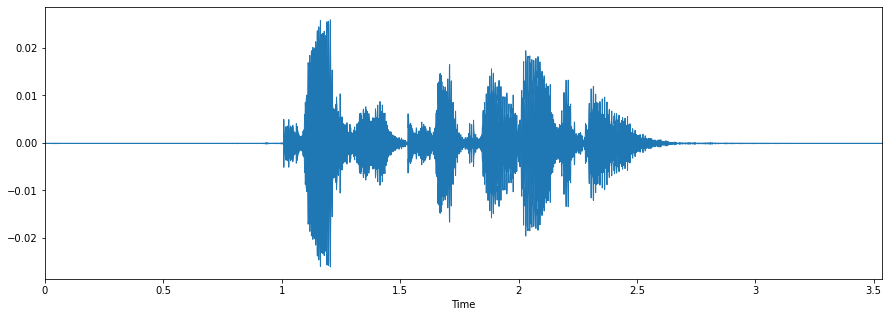

In [146]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [147]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('male_calm.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [148]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-58.802044,-57.447464,-58.8965,-58.750996,-57.405678,-60.078487,-63.426796,-62.638535,-61.082741,-60.234661


In [149]:
twodim= np.expand_dims(livedf2, axis=2)
livepreds = loaded_model.predict(twodim, batch_size=32,verbose=1)

1/1 [==============================] - 0s 4ms/step


In [150]:
livepreds

array([[5.9078443e-06, 2.1422653e-09, 1.8768240e-10, 1.5675383e-06,
        1.2447101e-09, 7.3974516e-04, 9.8763436e-01, 3.5977443e-03,
        3.8309770e-03, 4.1896310e-03]], dtype=float32)

In [151]:
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_calm'], dtype=object)